In [2]:
# mounting google drive to colab virtual machine

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab_Notebooks/Money_Laundering_Dataset'

/content/drive/MyDrive/Colab_Notebooks/Money_Laundering_Dataset


In [4]:
!pip install torch-geometric

     |████████████████████████████████| 222 kB 5.3 MB/s 
     |████████████████████████████████| 376 kB 34.6 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388143 sha256=7230a13e35643577d9b020b26f15fb12de47775252bc22b1fd4d3b66d1eef1cc
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric


In [5]:
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 3.4 MB/s 


In [6]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 3.4 MB/s 


In [7]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch_scatter
import torch_sparse
import torch_geometric
torch.manual_seed(42)


In [8]:
print(torch.__version__)
print(torch.version.cuda)

1.9.0+cu102
10.2


In [9]:
transaction=pd.read_csv('transactions_alerttype.csv')

In [10]:
transaction.ALERT_TYPE.fillna('NA',inplace=True)

In [11]:
for c in transaction.columns:
  if transaction[c].dtype =='object':
    print(f'{c} --> {transaction[c].unique()}')

TX_TYPE --> ['TRANSFER']
ALERT_TYPE --> ['NA' 'fan_in' 'cycle']


In [12]:
Counter(transaction.ALERT_TYPE)

Counter({'NA': 117358, 'cycle': 96, 'fan_in': 79})

In [13]:
accounts=pd.read_csv('accounts.csv')

In [14]:
for c in accounts.columns:
  if accounts[c].dtype =='object' and c!='CUSTOMER_ID':
    print(f'{c} --> {accounts[c].unique()}')

COUNTRY --> ['US']
ACCOUNT_TYPE --> ['I']


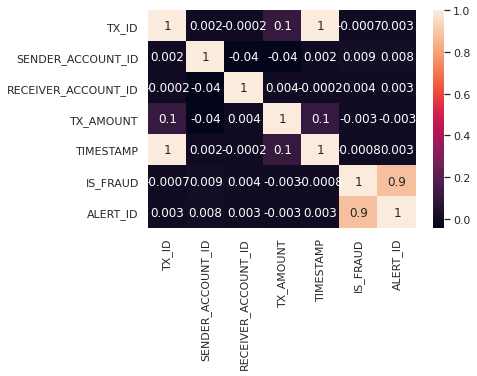

In [15]:
sns.heatmap(transaction.corr(),annot=True,fmt='.1g')

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


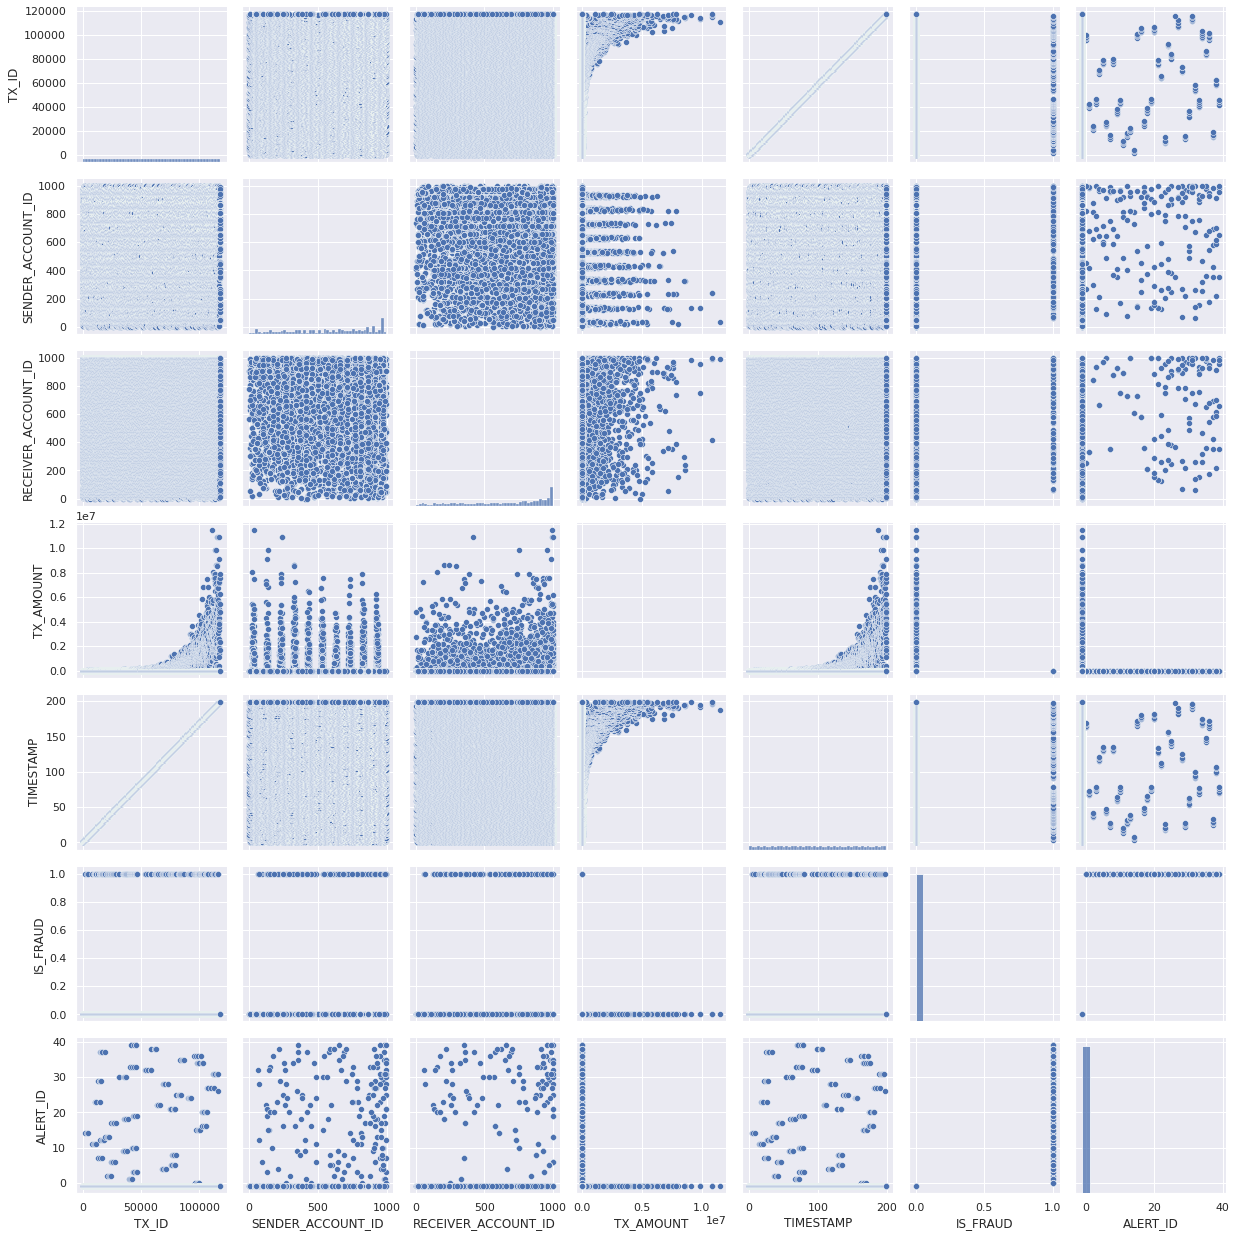

In [ ]:
sns.pairplot(transaction)

In [16]:
transaction.drop(columns='TX_TYPE',inplace=True)

In [17]:
transaction.IS_FRAUD=transaction.IS_FRAUD.astype(int)

In [18]:
transaction_final=pd.get_dummies(transaction)

In [19]:
accounts.drop(columns=['COUNTRY','ACCOUNT_TYPE','CUSTOMER_ID'],inplace=True)

In [20]:
accounts.IS_FRAUD=accounts.IS_FRAUD.astype(int)

In [21]:
node_features=accounts.drop(columns='IS_FRAUD')
node_features.head()

,ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID
0,0,184.44,1
1,1,175.80,1
2,2,142.06,1
3,3,125.89,1
4,4,151.13,1


In [22]:
transaction_index=transaction_final[['SENDER_ACCOUNT_ID','RECEIVER_ACCOUNT_ID']]

In [23]:
transaction_index.head()

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID
0,959,450
1,245,324
2,507,980
3,507,919
4,507,962


In [24]:
node_feats=[]
for i in range(len(node_features)):
  node_feats.append(list(node_features.iloc[i]))

In [25]:
node_feats=torch.tensor(node_feats,dtype=torch.float)

In [26]:
label=list(accounts['IS_FRAUD'])

In [27]:
label=torch.tensor(label,dtype=torch.int64)

In [28]:
edge_index=[]
for i in range(len(transaction_index)):
  edge_index.append(list(transaction_index.iloc[i]))

In [29]:
edge_index=torch.tensor(edge_index).T

In [30]:
edge_index.shape

torch.Size([2, 117533])

In [31]:
transaction_feats=transaction_final.drop(columns=['SENDER_ACCOUNT_ID','RECEIVER_ACCOUNT_ID','TX_ID'])

In [32]:
transaction_feats

,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_NA,ALERT_TYPE_cycle,ALERT_TYPE_fan_in
0,406.85,0,0,-1,1,0,0
1,469.41,0,0,-1,1,0,0
2,17.25,0,0,-1,1,0,0
3,17.25,0,0,-1,1,0,0
4,17.25,0,0,-1,1,0,0
...,...,...,...,...,...,...,...
117528,1693722.87,199,0,-1,1,0,0
117529,361.01,199,0,-1,1,0,0
117530,460.04,199,0,-1,1,0,0
117531,593.30,199,0,-1,1,0,0


In [33]:
edge_feats=[]
for i in range(len(transaction_feats)):
  edge_feats.append(list(transaction_feats.iloc[i]))

In [34]:
edge_feats=torch.tensor(edge_feats,dtype=torch.float)

In [35]:
edge_feats.shape

torch.Size([117533, 7])

In [36]:
from torch_geometric.data import Data,Dataset

In [37]:

data=Data(x=node_feats,
          edge_index=edge_index,
          edge_attr=edge_feats,
          y=label,
          train_mask=torch.ones(1000)>=1)

In [38]:
data

Data(edge_attr=[117533, 7], edge_index=[2, 117533], train_mask=[1000], x=[1000, 3], y=[1000])

In [39]:
data.x

tensor([[  0.0000, 184.4400,   1.0000],
        [  1.0000, 175.8000,   1.0000],
        [  2.0000, 142.0600,   1.0000],
        ...,
        [997.0000, 385.8800,   5.0000],
        [998.0000, 389.7200,   5.0000],
        [999.0000, 296.0800,   5.0000]])

In [40]:
from torch_geometric.data import DataLoader

In [9]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [42]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, 3)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=3, bias=True)
)


In [43]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x ,data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.1994
Epoch: 100, Loss: 0.7134
Epoch: 200, Loss: 0.7135
Epoch: 300, Loss: 0.7144
Epoch: 400, Loss: 0.7142
Epoch: 500, Loss: 0.7135
Epoch: 600, Loss: 0.7140
Epoch: 700, Loss: 0.7134
Epoch: 800, Loss: 0.7130
Epoch: 900, Loss: 0.7135
Epoch: 1000, Loss: 0.7134


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


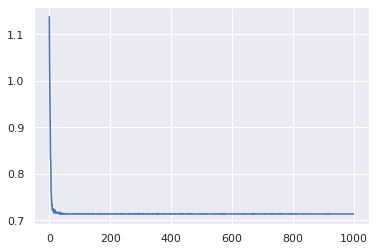

In [44]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses[1:]] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

Calculate test metric

In [45]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

AttributeError: ignored